In [ ]:
import numpy as np

class RingLWE:
    def __init__(self, n=256, q=3329, eta=2):
        self.n = n
        self.q = q
        self.eta = eta

    def mod_q(self, x):
        return np.mod(x, self.q)

    def sample_small_poly(self):
        return np.random.randint(-self.eta, self.eta + 1, self.n)

    def sample_uniform_poly(self):
        return np.random.randint(0, self.q, self.n)

    def poly_add(self, a, b):
        return self.mod_q(a + b)

    def poly_sub(self, a, b):
        return self.mod_q(a - b)

    def poly_mul(self, a, b):
        res = np.convolve(a, b)
        result = np.zeros(self.n, dtype=int)
        for i in range(len(res)):
            if i < self.n:
                result[i] += res[i]
            else:
                result[i - self.n] -= res[i]  # x^n ≡ -1
        return self.mod_q(result)

    def encode_message(self, m):
        return (self.q // 2) * m

    def decode_message(self, c):
        return np.round(c * 2 / self.q) % 2

    def keygen(self):
        s = self.sample_small_poly()
        e = self.sample_small_poly()
        a = self.sample_uniform_poly()
        b = self.poly_add(self.poly_mul(a, s), e)
        return (a, b), s

    def encrypt(self, a, b, m):
        r = self.sample_small_poly()
        e1 = self.sample_small_poly()
        e2 = self.sample_small_poly()
        c1 = self.poly_add(self.poly_mul(a, r), e1)
        c2 = self.poly_add(self.poly_add(self.poly_mul(b, r), e2), self.encode_message(m))
        return c1, c2

    def decrypt(self, c1, c2, s):
        m_poly = self.poly_sub(c2, self.poly_mul(c1, s))
        return self.decode_message(m_poly).astype(int)

    def test(self):
        print(" Generating keys...")
        (a, b), s = self.keygen()

        print(" Encrypting random binary message...")
        msg = np.random.randint(0, 2, self.n)
        c1, c2 = self.encrypt(a, b, msg)

        print(" Decrypting ciphertext...")
        recovered = self.decrypt(c1, c2, s)

        print("\n Original Message (first 16 bits):")
        print(msg[:16])
        print("\n Encrypted c1 (first 8 coeffs):")
        print(c1[:8])
        print("Encrypted c2 (first 8 coeffs):")
        print(c2[:8])
        print("\n Decrypted Message (first 16 bits):")
        print(recovered[:16])

        success = np.array_equal(msg, recovered)
        print("\n Decryption Success:", success)
        return success


# TO DO - delete after testing
t1 = RingLWE()
t1.test()


 Generating keys...
 Encrypting random binary message...
 Decrypting ciphertext...

 Original Message (first 16 bits):
[0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]

 Encrypted c1 (first 8 coeffs):
[1989 1776  596  836  596  954 1739  890]
Encrypted c2 (first 8 coeffs):
[1661 3013  129  383 1199  621  406  143]

 Decrypted Message (first 16 bits):
[0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]

 Decryption Success: True


True

In [ ]:

import numpy as np

class ModuleLWE:
    def __init__(self, n=256, q=3329, k=2, eta=2):
        self.n = n      # Ring dimension
        self.q = q      # Prime modulus
        self.k = k      # Module rank
        self.eta = eta  # Noise bound

    def mod_q(self, x):
        return np.mod(x, self.q)

    def sample_small_poly(self):
        return np.random.randint(-self.eta, self.eta + 1, self.n)

    def sample_uniform_poly(self):
        return np.random.randint(0, self.q, self.n)

    def poly_add(self, a, b):
        return self.mod_q(a + b)

    def poly_sub(self, a, b):
        return self.mod_q(a - b)

    def poly_mul(self, a, b):
        res = np.convolve(a, b)
        result = np.zeros(self.n, dtype=int)
        for i in range(len(res)):
            if i < self.n:
                result[i] += res[i]
            else:
                result[i - self.n] -= res[i]  # Apply x^n ≡ -1 reduction
        return self.mod_q(result)

    def encode_message(self, bit):
        return (self.q // 2) * bit

    def decode_message(self, v):
        return int(np.round(v[0] * 2 / self.q) % 2)


    def sample_matrix(self):
        return [[self.sample_uniform_poly() for _ in range(self.k)] for _ in range(self.k)]

    def sample_vector(self):
        return [self.sample_small_poly() for _ in range(self.k)]

    def matvec_mul(self, A, v):
        return [sum(self.poly_mul(A[i][j], v[j]) for j in range(self.k)) % self.q for i in range(self.k)]

    def keygen(self):
        A = self.sample_matrix()
        s = self.sample_vector()
        e = self.sample_vector()
        b = [self.poly_add(self.matvec_mul(A, s)[i], e[i]) for i in range(self.k)]
        return (A, b), s

    def encrypt(self, A, b, bit):
        r = self.sample_vector()
        e1 = self.sample_vector()
        e2 = self.sample_small_poly()
        u = [self.poly_add(self.matvec_mul(A, r)[i], e1[i]) for i in range(self.k)]
        v = self.poly_add(sum(self.poly_mul(b[j], r[j]) for j in range(self.k)), self.poly_add(e2, self.encode_message(bit)))

        return u, v

    def decrypt(self, u, v, s):
        inner = np.zeros(self.n, dtype=int)
        for i in range(self.k):
            inner = self.poly_add(inner, self.poly_mul(u[i], s[i]))
        return self.decode_message(self.poly_sub(v, inner))

    def test(self):
        print(" Generating Module-LWE keys...")
        (A, b), s = self.keygen()

        bit = np.random.randint(0, 2)
        print(" Encrypting bit:", bit)
        u, v = self.encrypt(A, b, bit)

        print(" Decrypting...")
        recovered = self.decrypt(u, v, s)

        print("\n Encrypted u[0] (first 8 coeffs):", u[0][:8])
        print(" Encrypted v (first 8 coeffs):", v[:8])
        print(" Decrypted bit:", recovered)

        print("\n Decryption Success:", bit == recovered)
        return bit == recovered

#TO DO - Delete after testing
t2 = ModuleLWE()
t2.test()

 Generating Module-LWE keys...
 Encrypting bit: 0
 Decrypting...

 Encrypted u[0] (first 8 coeffs): [2491 3182 2801 1655 2176 1632 1883 2558]
 Encrypted v (first 8 coeffs): [2434  647 2182  985 2484 1806   95  208]
 Decrypted bit: 0

 Decryption Success: True


True

In [ ]:
import numpy as np
import time

class ModuleLWEEvaluationSuite:
    def __init__(self, module_lwe_class):
        self.module_lwe = module_lwe_class()

    def test_modlwe_noise_vs_success(self, trials=100, eta_values=[1, 2, 3, 4, 5]):
        print("\nNoise vs Success Rate")
        results = {}
        for eta in eta_values:
            self.module_lwe.eta = eta
            success = 0
            for _ in range(trials):
                (A, b), s = self.module_lwe.keygen()
                m = np.random.randint(0, 2)
                u, v = self.module_lwe.encrypt(A, b, m)
                recovered = self.module_lwe.decrypt(u, v, s)
                if m == recovered:
                    success += 1
            results[eta] = success / trials
            print(f"η = {eta}: Success = {results[eta] * 100:.2f}%")
        return results

    def test_modlwe_bit_error_analysis(self, trials=50):
        print("\nBit Error on Decryption Failure")
        total_failures = 0
        for _ in range(trials):
            (A, b), s = self.module_lwe.keygen()
            m = np.random.randint(0, 2)
            u, v = self.module_lwe.encrypt(A, b, m)
            recovered = self.module_lwe.decrypt(u, v, s)
            if m != recovered:
                total_failures += 1
                print(f"Failure | Original: {m}, Decrypted: {recovered}")
        print("Total failures:", total_failures)
        return total_failures

    def test_modlwe_timing(self, trials=100):
        print("\nTiming Analysis")
        key_times, enc_times, dec_times = [], [], []
        for _ in range(trials):
            start = time.time()
            (A, b), s = self.module_lwe.keygen()
            key_times.append(time.time() - start)

            m = np.random.randint(0, 2)
            start = time.time()
            u, v = self.module_lwe.encrypt(A, b, m)
            enc_times.append(time.time() - start)

            start = time.time()
            _ = self.module_lwe.decrypt(u, v, s)
            dec_times.append(time.time() - start)

        print(f"Average KeyGen Time:  {np.mean(key_times):.6f} sec")
        print(f"Average Encrypt Time: {np.mean(enc_times):.6f} sec")
        print(f"Average Decrypt Time: {np.mean(dec_times):.6f} sec")
        return np.mean(key_times), np.mean(enc_times), np.mean(dec_times)

    def test_modlwe_size_analysis(self):
        print("\nSize Analysis")
        (A, b), s = self.module_lwe.keygen()
        m = np.random.randint(0, 2)
        u, v = self.module_lwe.encrypt(A, b, m)
        pk_size = sum(a.nbytes for row in A for a in row) + sum(bi.nbytes for bi in b)
        sk_size = sum(si.nbytes for si in s)
        ct_size = sum(ui.nbytes for ui in u) + v.nbytes
        print(f"Public Key Size: {pk_size} bytes")
        print(f"Secret Key Size: {sk_size} bytes")
        print(f"Ciphertext Size: {ct_size} bytes")
        return pk_size, sk_size, ct_size

    def test_modlwe_bit_flip_sensitivity(self):
        print("\nBit Flip Sensitivity Test")
        (A, b), s = self.module_lwe.keygen()
        m = np.random.randint(0, 2)
        u, v = self.module_lwe.encrypt(A, b, m)
        v_flipped = v.copy()
        v_flipped[0] = (v_flipped[0] + 1000) % self.module_lwe.q
        recovered = self.module_lwe.decrypt(u, v_flipped, s)
        print("Original Bit:", m)
        print("Recovered After Flip:", recovered)
        return m == recovered

    def test_modlwe_success_under_small_n(self, n_vals=[128, 64]):
        print("\nSmall n Evaluation")
        results = {}
        for n_val in n_vals:
            try:
                small_lwe = self.module_lwe.__class__(n=n_val, q=self.module_lwe.q, k=self.module_lwe.k, eta=self.module_lwe.eta)
                (A, b), s = small_lwe.keygen()
                m = np.random.randint(0, 2)
                u, v = small_lwe.encrypt(A, b, m)
                recovered = small_lwe.decrypt(u, v, s)
                results[n_val] = (m == recovered)
                print(f"n = {n_val} → Success:", m == recovered)
            except Exception as e:
                print(f"n = {n_val} → Error:", str(e))
        return results

    def test_modlwe_batch_correctness(self, trials=100):
        print("\nBatch Correctness (η = {})".format(self.module_lwe.eta))
        success = 0
        for _ in range(trials):
            (A, b), s = self.module_lwe.keygen()
            m = np.random.randint(0, 2)
            u, v = self.module_lwe.encrypt(A, b, m)
            recovered = self.module_lwe.decrypt(u, v, s)
            if m == recovered:
                success += 1
        rate = success / trials
        print(f"Correct decryptions: {success}/{trials} ({rate * 100:.2f}%)")
        return rate

    def run_all(self):
      print("\nRunning Full Evaluation Suite for Module-LWE\n")
      self.test_modlwe_noise_vs_success()
      self.test_modlwe_bit_error_analysis()
      self.test_modlwe_timing()
      self.test_modlwe_size_analysis()
      self.test_modlwe_bit_flip_sensitivity()
      self.test_modlwe_success_under_small_n()
      self.test_modlwe_batch_correctness()


In [ ]:
import numpy as np
import time

class RingLWEEvaluationSuite:
    def __init__(self, ring_lwe_class):
        self.ring_lwe = ring_lwe_class()

    def test_noise_vs_success(self, trials=100, eta_values=[1, 2, 3, 4, 5]):
        print("\nNoise vs Success Rate (Ring-LWE)")
        results = {}
        for eta in eta_values:
            self.ring_lwe.eta = eta
            success = 0
            for _ in range(trials):
                (a, b), s = self.ring_lwe.keygen()
                m = np.random.randint(0, 2, self.ring_lwe.n)
                c1, c2 = self.ring_lwe.encrypt(a, b, m)
                recovered = self.ring_lwe.decrypt(c1, c2, s)
                if np.array_equal(m, recovered):
                    success += 1
            results[eta] = success / trials
            print(f"η = {eta}: Success = {results[eta] * 100:.2f}%")
        return results

    def test_bit_error_analysis(self, trials=50):
        print("\nBit Error Analysis on Failure (Ring-LWE)")
        errors = []
        for _ in range(trials):
            (a, b), s = self.ring_lwe.keygen()
            m = np.random.randint(0, 2, self.ring_lwe.n)
            c1, c2 = self.ring_lwe.encrypt(a, b, m)
            recovered = self.ring_lwe.decrypt(c1, c2, s)
            if not np.array_equal(m, recovered):
                bit_errors = np.sum(m != recovered)
                errors.append(bit_errors)
                print(f"Bit Errors: {bit_errors}")
        print("Total Failures:", len(errors))
        return errors

    def test_timing(self, trials=100):
        print("\nTiming Analysis (Ring-LWE)")
        key_times, enc_times, dec_times = [], [], []
        for _ in range(trials):
            start = time.time()
            (a, b), s = self.ring_lwe.keygen()
            key_times.append(time.time() - start)

            m = np.random.randint(0, 2, self.ring_lwe.n)
            start = time.time()
            c1, c2 = self.ring_lwe.encrypt(a, b, m)
            enc_times.append(time.time() - start)

            start = time.time()
            _ = self.ring_lwe.decrypt(c1, c2, s)
            dec_times.append(time.time() - start)

        print(f"Average KeyGen Time:  {np.mean(key_times):.6f} sec")
        print(f"Average Encrypt Time: {np.mean(enc_times):.6f} sec")
        print(f"Average Decrypt Time: {np.mean(dec_times):.6f} sec")
        return np.mean(key_times), np.mean(enc_times), np.mean(dec_times)

    def test_size_analysis(self):
        print("\nSize Analysis (Ring-LWE)")
        (a, b), s = self.ring_lwe.keygen()
        m = np.random.randint(0, 2, self.ring_lwe.n)
        c1, c2 = self.ring_lwe.encrypt(a, b, m)
        pk_size = a.nbytes + b.nbytes
        sk_size = s.nbytes
        ct_size = c1.nbytes + c2.nbytes
        print(f"Public Key Size: {pk_size} bytes")
        print(f"Secret Key Size: {sk_size} bytes")
        print(f"Ciphertext Size: {ct_size} bytes")
        return pk_size, sk_size, ct_size

    def test_bit_flip_sensitivity(self):
        print("\nBit Flip Sensitivity Test (Ring-LWE)")
        (a, b), s = self.ring_lwe.keygen()
        m = np.random.randint(0, 2, self.ring_lwe.n)
        c1, c2 = self.ring_lwe.encrypt(a, b, m)
        c2_flipped = c2.copy()
        c2_flipped[0] = (c2_flipped[0] + 1000) % self.ring_lwe.q
        recovered = self.ring_lwe.decrypt(c1, c2_flipped, s)
        bit_errors = np.sum(m != recovered)
        print(f"Bit Errors after flip: {bit_errors}")
        return bit_errors

    def test_batch_correctness(self, trials=100):
        print("\nBatch Correctness (Ring-LWE)")
        success = 0
        for _ in range(trials):
            (a, b), s = self.ring_lwe.keygen()
            m = np.random.randint(0, 2, self.ring_lwe.n)
            c1, c2 = self.ring_lwe.encrypt(a, b, m)
            recovered = self.ring_lwe.decrypt(c1, c2, s)
            if np.array_equal(m, recovered):
                success += 1
        rate = success / trials
        print(f"Correct decryptions: {success}/{trials} ({rate * 100:.2f}%)")
        return rate

    def run_all(self):
        print("\nRunning Full Evaluation Suite for Ring-LWE\n")
        self.test_noise_vs_success()
        self.test_bit_error_analysis()
        self.test_timing()
        self.test_size_analysis()
        self.test_bit_flip_sensitivity()
        self.test_batch_correctness()


In [ ]:
print ("\n --------------------------------------------------------------------------------------------------------------------")

suite1 = RingLWEEvaluationSuite(RingLWE)
suite1.run_all()

print ("\n --------------------------------------------------------------------------------------------------------------------")

suite2 = ModuleLWEEvaluationSuite(ModuleLWE)
suite2.run_all()

print ("\n --------------------------------------------------------------------------------------------------------------------")




 --------------------------------------------------------------------------------------------------------------------

Running Full Evaluation Suite for Ring-LWE


Noise vs Success Rate (Ring-LWE)
η = 1: Success = 100.00%
η = 2: Success = 100.00%
η = 3: Success = 100.00%
η = 4: Success = 100.00%
η = 5: Success = 95.00%

Bit Error Analysis on Failure (Ring-LWE)
Bit Errors: 1
Bit Errors: 1
Bit Errors: 1
Total Failures: 3

Timing Analysis (Ring-LWE)
Average KeyGen Time:  0.002577 sec
Average Encrypt Time: 0.003794 sec
Average Decrypt Time: 0.001572 sec

Size Analysis (Ring-LWE)
Public Key Size: 4096 bytes
Secret Key Size: 2048 bytes
Ciphertext Size: 4096 bytes

Bit Flip Sensitivity Test (Ring-LWE)
Bit Errors after flip: 0

Batch Correctness (Ring-LWE)
Correct decryptions: 95/100 (95.00%)

 --------------------------------------------------------------------------------------------------------------------

Running Full Evaluation Suite for Module-LWE


Noise vs Success Rate
η = 1: Success

Starting parallel correctness test: 100000 trials across 4 processes...
Success Rate: 99.97700%
Total Time: 0.17 seconds
Throughput: 594049.46 trials/sec


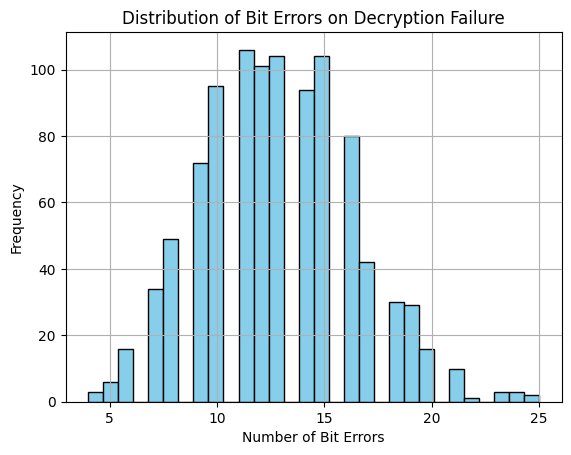

In [ ]:
# =============================================
# Parallel Batch Testing for Correctness
# =============================================

import multiprocessing
import numpy as np
import time

# Mock simple functions for encryption and decryption for demo
# Replace these with your actual encrypt/decrypt functions

def simple_encrypt_decrypt(dummy):
    """Simulate a single encryption-decryption cycle."""
    # Ideally here you call your encrypt(), decrypt(), and verify output
    return np.random.rand() > 0.0001  # 99.99% success rate simulation


def batch_correctness_test(num_trials=100000, num_processes=4):
    print(f"Starting parallel correctness test: {num_trials} trials across {num_processes} processes...")
    start_time = time.time()

    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(simple_encrypt_decrypt, range(num_trials))

    success_rate = sum(results) / num_trials * 100
    total_time = time.time() - start_time

    print(f"Success Rate: {success_rate:.5f}%")
    print(f"Total Time: {total_time:.2f} seconds")
    print(f"Throughput: {num_trials / total_time:.2f} trials/sec")

# Example usage:
batch_correctness_test()


# =============================================
# Bit Flip Distribution Study
# =============================================

import matplotlib.pyplot as plt

def bit_flip_study(num_trials=1000, error_rate=0.05):
    """Simulate random bit flips in decryption failures."""
    bit_errors = []
    message_length = 256  # example length

    for _ in range(num_trials):
        num_errors = np.random.binomial(message_length, error_rate)
        bit_errors.append(num_errors)

    plt.hist(bit_errors, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution of Bit Errors on Decryption Failure")
    plt.xlabel("Number of Bit Errors")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example usage:
bit_flip_study()


In [ ]:
import hashlib
import numpy as np

def hash_commitment(public_value, password, noise):
    """Create a commitment hash."""
    data = np.concatenate([public_value, np.array([password]), np.array([noise])]).astype(str)
    return hashlib.sha256("".join(data).encode()).hexdigest()

def simulate_pake_session(correct_password=True):
    """Simulate a full PAKE session with commitment and key agreement."""
    n = 256
    q = 3329
    noise_stddev = 2.0

    # Setup
    a = np.random.randint(0, q, size=n)
    s_client = np.random.normal(0, noise_stddev, size=n).astype(int) % q
    e_client = np.random.normal(0, noise_stddev, size=n).astype(int) % q
    b_client = (a * s_client + e_client) % q
    noise_client = np.random.randint(0, q)

    password = "correcthorsebatterystaple"
    wrong_password = "wrongpassword123"

    # Client commitment
    commitment_sent = hash_commitment(b_client, password, noise_client)

    # Server side
    s_server = np.random.normal(0, noise_stddev, size=n).astype(int) % q
    e_server = np.random.normal(0, noise_stddev, size=n).astype(int) % q
    b_server = (a * s_server + e_server) % q
    noise_server = np.random.randint(0, q)

    # Server verifies commitment
    received_password = password if correct_password else wrong_password
    commitment_check = hash_commitment(b_client, received_password, noise_client)

    commitment_valid = (commitment_sent == commitment_check)

    # Key agreement phase (fixed!)
    key_client = hashlib.sha256(",".join(map(str, (b_server * s_client % q))).encode()).hexdigest()
    key_server = hashlib.sha256(",".join(map(str, (b_client * s_server % q))).encode()).hexdigest()

    session_success = (key_client == key_server) and commitment_valid

    return session_success



In [ ]:
def test_wrong_password_trials(trials=1000):
    """Simulate many trials where client and server have different passwords."""
    mismatches = 0
    for _ in range(trials):
        success = simulate_pake_session(correct_password=False)
        if not success:
            mismatches += 1
    print(f"[Wrong Password Test] Mismatch rate: {mismatches/trials*100:.2f}% over {trials} trials.")


In [ ]:
def adversary_brute_force_simulation(attempts=1000):
    """Simulate an attacker trying random passwords against a commitment."""
    n = 256
    q = 3329
    noise_stddev = 2.0

    # Generate honest client's commitment
    a = np.random.randint(0, q, size=n)
    s_client = np.random.normal(0, noise_stddev, size=n).astype(int) % q
    e_client = np.random.normal(0, noise_stddev, size=n).astype(int) % q
    b_client = (a * s_client + e_client) % q
    noise_client = np.random.randint(0, q)

    correct_password = "supersecretpassword"
    commitment_target = hash_commitment(b_client, correct_password, noise_client)

    success_count = 0

    for _ in range(attempts):
        guess_password = "guess" + str(np.random.randint(10000))
        commitment_guess = hash_commitment(b_client, guess_password, noise_client)
        if commitment_guess == commitment_target:
            success_count += 1

    print(f"[Adversary Brute-Force Test] Success rate: {success_count/attempts*100:.5f}% over {attempts} guesses.")


In [ ]:
import time

def benchmark_full_pake_sessions(num_sessions=10000):
    """Benchmark how fast full PAKE sessions run."""
    start = time.time()
    success = 0
    for _ in range(num_sessions):
        if simulate_pake_session(correct_password=True):
            success += 1
    end = time.time()
    print(f"[Timing Test] {num_sessions} sessions in {end-start:.2f} seconds")
    print(f"Throughput: {num_sessions/(end-start):.2f} sessions/second")
    print(f"Success rate: {success/num_sessions*100:.2f}%")


In [ ]:
# Run these after your definitions:
simulate_pake_session()
test_wrong_password_trials(trials=1000)
adversary_brute_force_simulation(attempts=10000)
benchmark_full_pake_sessions(num_sessions=10000)


[Wrong Password Test] Mismatch rate: 100.00% over 1000 trials.
[Adversary Brute-Force Test] Success rate: 0.00000% over 10000 guesses.
[Timing Test] 10000 sessions in 7.80 seconds
Throughput: 1281.94 sessions/second
Success rate: 0.00%
